In [1]:
#!/usr/bin/env python
"""
Prepare Few-Shot Examples for Organ Detection Evaluation
This script creates balanced test sets and few-shot example plans
"""

# Cell 1: Setup and imports
import os
import sys
import json
from pathlib import Path
from datetime import datetime

# Add src to path
ROOT_DIR = "../.."
sys.path.append(os.path.join(ROOT_DIR, 'src'))

# Import the new few-shot selection module
from few_shot_selection import (
    build_presence_matrix,
    select_balanced_indices, 
    build_fewshot_plan,
    save_balanced_indices,
    save_fewshot_plan,
    load_balanced_indices,
    load_fewshot_plan
)

from datasets import load_dataset
import numpy as np

print("✓ Modules imported")

✓ Modules imported


In [2]:
# Cell 2: Configuration
CONFIG = {
    "n_test_samples": 100,  # Number of balanced test samples
    "n_pos_examples": 1,    # Positive examples per organ
    "n_neg_easy": 1,        # Easy negative examples per organ  
    "n_neg_hard": 1,        # Hard negative examples per organ
    "min_pixels": 50,       # Minimum pixels for organ presence
    "seed": 42,             # Random seed for reproducibility
    "output_dir": Path(ROOT_DIR) / "data_info" / "cholecseg8k"
}

print(f"Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  n_test_samples: 100
  n_pos_examples: 1
  n_neg_easy: 1
  n_neg_hard: 1
  min_pixels: 50
  seed: 42
  output_dir: ../../data_info/cholecseg8k


In [3]:
# Cell 3: Load dataset
print("\n📊 Loading CholecSeg8k dataset...")
dataset = load_dataset("minwoosun/CholecSeg8k")
train_size = len(dataset['train'])
print(f"✓ Dataset loaded: {train_size} training samples")


📊 Loading CholecSeg8k dataset...
✓ Dataset loaded: 8080 training samples


In [4]:
# Cell 4: Build presence matrix
print("\n🔨 Building presence matrix for all training samples...")
print("This may take a few minutes...")

# Check if presence matrix is already cached
cache_file = CONFIG["output_dir"] / f"presence_matrix_train_{train_size}.npz"
indices_file = CONFIG["output_dir"] / f"presence_indices_train_{train_size}.json"

if cache_file.exists() and indices_file.exists():
    print("Loading cached presence matrix...")
    data = np.load(cache_file)
    Y = data['Y']
    with open(indices_file, 'r') as f:
        all_indices = json.load(f)['indices']
    print(f"✓ Loaded cached presence matrix: shape {Y.shape}")
else:
    Y, all_indices = build_presence_matrix(
        dataset, 
        split="train", 
        indices=None,  # Use all samples
        min_pixels=CONFIG["min_pixels"]
    )
    
    # Save for future use
    CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)
    np.savez_compressed(cache_file, Y=Y)
    with open(indices_file, 'w') as f:
        json.dump({'indices': all_indices}, f)
    print(f"✓ Built presence matrix: shape {Y.shape}")
    print(f"  Cached to: {cache_file}")


🔨 Building presence matrix for all training samples...
This may take a few minutes...
Loading cached presence matrix...
✓ Loaded cached presence matrix: shape (8080, 12)


In [5]:
# Cell 5: Analyze organ distribution
print("\n📊 Organ presence statistics:")
from cholecseg8k_utils import ID2LABEL, LABEL_IDS

organ_counts = Y.sum(axis=0)
total_samples = Y.shape[0]

for i, class_id in enumerate(LABEL_IDS):
    organ_name = ID2LABEL[class_id]
    count = organ_counts[i]
    percentage = (count / total_samples) * 100
    print(f"  {organ_name:25} {count:5d} samples ({percentage:5.1f}%)")



📊 Organ presence statistics:
  Abdominal Wall             7255 samples ( 89.8%)
  Liver                      8080 samples (100.0%)
  Gastrointestinal Tract     4556 samples ( 56.4%)
  Fat                        7510 samples ( 92.9%)
  Grasper                    6020 samples ( 74.5%)
  Connective Tissue          1600 samples ( 19.8%)
  Blood                       692 samples (  8.6%)
  Cystic Duct                 241 samples (  3.0%)
  L-hook Electrocautery      2251 samples ( 27.9%)
  Gallbladder                6860 samples ( 84.9%)
  Hepatic Vein                316 samples (  3.9%)
  Liver Ligament              240 samples (  3.0%)


In [6]:
# Cell 6: Select balanced test set
print(f"\n🎯 Selecting {CONFIG['n_test_samples']} balanced test samples...")

# Check if balanced indices already exist
balanced_file = CONFIG["output_dir"] / f"balanced_indices_train_{CONFIG['n_test_samples']}.json"

if balanced_file.exists():
    print(f"✓ Balanced indices already exist: {balanced_file.name}")
    print("  Loading existing indices...")
    balanced_indices = load_balanced_indices(balanced_file)
else:
    print("  Selecting new balanced indices...")
    balanced_indices = select_balanced_indices(
        Y, 
        all_indices, 
        n_select=CONFIG["n_test_samples"],
        seed=CONFIG["seed"]
    )

# Analyze balance
Y_balanced = Y[[all_indices.index(i) for i in balanced_indices]]
balanced_counts = Y_balanced.sum(axis=0)

print("Balanced set organ distribution:")
for i, class_id in enumerate(LABEL_IDS):
    organ_name = ID2LABEL[class_id]
    count = balanced_counts[i]
    percentage = (count / CONFIG["n_test_samples"]) * 100
    print(f"  {organ_name:25} {count:3d} samples ({percentage:5.1f}%)")




🎯 Selecting 100 balanced test samples...
✓ Balanced indices already exist: balanced_indices_train_100.json
  Loading existing indices...
Balanced set organ distribution:
  Abdominal Wall             97 samples ( 97.0%)
  Liver                     100 samples (100.0%)
  Gastrointestinal Tract     80 samples ( 80.0%)
  Fat                       100 samples (100.0%)
  Grasper                    67 samples ( 67.0%)
  Connective Tissue          67 samples ( 67.0%)
  Blood                      34 samples ( 34.0%)
  Cystic Duct                34 samples ( 34.0%)
  L-hook Electrocautery      39 samples ( 39.0%)
  Gallbladder                67 samples ( 67.0%)
  Hepatic Vein               33 samples ( 33.0%)
  Liver Ligament             33 samples ( 33.0%)


In [7]:
# Cell 7: Save balanced test indices
if not balanced_file.exists():
    balanced_file = save_balanced_indices(
        balanced_indices,
        split="train",
        n_select=CONFIG["n_test_samples"],
        output_dir=CONFIG["output_dir"]
    )
    print(f"✓ Saved balanced indices to: {balanced_file}")
else:
    print(f"✓ Using existing balanced indices: {balanced_file}")


✓ Using existing balanced indices: ../../data_info/cholecseg8k/balanced_indices_train_100.json


In [8]:
# Cell 8: Build few-shot plan (positives + easy negatives)
print("\n🎯 Building few-shot plan (positives + easy negatives)...")

# Check if file already exists
expected_filename = f"fewshot_plan_train_pos{CONFIG['n_pos_examples']}_neg{CONFIG['n_neg_easy']}_seed{CONFIG['seed'] + 1}_excl{CONFIG['n_test_samples']}.json"
plan_easy_file = CONFIG["output_dir"] / expected_filename

if plan_easy_file.exists():
    print(f"✓ Few-shot plan (easy) already exists: {plan_easy_file.name}")
    print("  Loading existing plan...")
    plan_easy = load_fewshot_plan(plan_easy_file)
else:
    print("  Building new plan...")
    plan_easy = build_fewshot_plan(
        dataset,
        split="train",
        balanced_indices=balanced_indices,
        n_pos=CONFIG["n_pos_examples"],
        n_neg_easy=CONFIG["n_neg_easy"],
        n_neg_hard=0,  # No hard negatives in this version
        min_pixels=CONFIG["min_pixels"],
        seed=CONFIG["seed"] + 1  # Different seed for few-shot selection
    )
    plan_easy_file = save_fewshot_plan(plan_easy, CONFIG["output_dir"])



🎯 Building few-shot plan (positives + easy negatives)...
✓ Few-shot plan (easy) already exists: fewshot_plan_train_pos1_neg1_seed43_excl100.json
  Loading existing plan...


In [9]:
# Cell 9: Build few-shot plan with confuser-based hard negatives
print("\n🎯 Building few-shot plan with confuser-based hard negatives...")
print("  Note: Using diverse selection (min 100 frames apart) to avoid similar consecutive frames")

# Check if file already exists
expected_filename = f"fewshot_plan_train_pos{CONFIG['n_pos_examples']}_nege{CONFIG['n_neg_easy']}_negh{CONFIG['n_neg_hard']}_seed{CONFIG['seed'] + 2}_excl{CONFIG['n_test_samples']}.json"
plan_hard_file = CONFIG["output_dir"] / expected_filename

if plan_hard_file.exists():
    print(f"✓ Few-shot plan (confuser hard) already exists: {plan_hard_file.name}")
    print("  Loading existing plan...")
    plan_hard = load_fewshot_plan(plan_hard_file)
else:
    print("  Building new plan...")
    plan_hard = build_fewshot_plan(
        dataset,
        split="train", 
        balanced_indices=balanced_indices,
        n_pos=CONFIG["n_pos_examples"],
        n_neg_easy=CONFIG["n_neg_easy"],
        n_neg_hard=CONFIG["n_neg_hard"],
        min_pixels=CONFIG["min_pixels"],
        seed=CONFIG["seed"] + 2  # Different seed
    )
    plan_hard_file = save_fewshot_plan(plan_hard, CONFIG["output_dir"])



🎯 Building few-shot plan with confuser-based hard negatives...
  Note: Using diverse selection (min 100 frames apart) to avoid similar consecutive frames
✓ Few-shot plan (confuser hard) already exists: fewshot_plan_train_pos1_nege1_negh1_seed44_excl100.json
  Loading existing plan...


In [10]:
# Cell 9b: Build few-shot plan with near-miss hard negatives (for pointing tasks)
print("\n🎯 Building few-shot plan with near-miss hard negatives for pointing tasks...")

from few_shot_selection import build_fewshot_plan_with_nearmiss

# Check if file already exists
nearmiss_filename = f"fewshot_plan_train_pos{CONFIG['n_pos_examples']}_neg{CONFIG['n_neg_easy']}_nearmiss{CONFIG['n_neg_hard']}_seed{CONFIG['seed'] + 3}_excl{CONFIG['n_test_samples']}.json"
plan_nearmiss_file = CONFIG["output_dir"] / nearmiss_filename

if plan_nearmiss_file.exists():
    print(f"✓ Few-shot plan (near-miss) already exists: {plan_nearmiss_file.name}")
    print("  Loading existing plan...")
    plan_nearmiss = load_fewshot_plan(plan_nearmiss_file)
else:
    print("  Building new plan...")
    plan_nearmiss = build_fewshot_plan_with_nearmiss(
        dataset,
        split="train",
        balanced_indices=balanced_indices,
        n_pos=CONFIG["n_pos_examples"],
        n_neg_easy=CONFIG["n_neg_easy"],
        n_near_miss=CONFIG["n_neg_hard"],  # Use same number as hard negatives
        min_pixels=CONFIG["min_pixels"],
        seed=CONFIG["seed"] + 3  # Different seed
    )
    
    # Save the plan
    with open(plan_nearmiss_file, "w") as f:
        json.dump(plan_nearmiss, f, indent=2)
    
    print(f"  Saved near-miss plan to: {plan_nearmiss_file}")

# Print summary
print("\nNear-miss plan summary:")
for class_id_str, info in plan_nearmiss["plan"].items():
    name = info["name"]
    n_pos = len(info["positives"])
    n_neg_e = len(info["negatives_easy"])
    n_near = len(info["near_miss"])
    print(f"  {name:25} pos={n_pos}, neg_easy={n_neg_e}, near_miss={n_near}")



🎯 Building few-shot plan with near-miss hard negatives for pointing tasks...
✓ Few-shot plan (near-miss) already exists: fewshot_plan_train_pos1_neg1_nearmiss1_seed45_excl100.json
  Loading existing plan...

Near-miss plan summary:
  Abdominal Wall            pos=1, neg_easy=1, near_miss=1
  Liver                     pos=1, neg_easy=0, near_miss=1
  Gastrointestinal Tract    pos=1, neg_easy=1, near_miss=1
  Fat                       pos=1, neg_easy=1, near_miss=1
  Grasper                   pos=1, neg_easy=1, near_miss=1
  Connective Tissue         pos=1, neg_easy=1, near_miss=1
  Blood                     pos=1, neg_easy=1, near_miss=1
  Cystic Duct               pos=1, neg_easy=1, near_miss=1
  L-hook Electrocautery     pos=1, neg_easy=1, near_miss=1
  Gallbladder               pos=1, neg_easy=1, near_miss=1
  Hepatic Vein              pos=1, neg_easy=1, near_miss=1
  Liver Ligament            pos=1, neg_easy=1, near_miss=1



📊 Visualizing few-shot examples...

📚 Understanding Easy vs Hard Negatives:
EASY NEGATIVES: Random images that don't contain the target organ
  - Simple case: organ is clearly absent
  - May be visually very different from positive examples

HARD NEGATIVES: Images containing confusing/similar organs
  - Challenging case: contains organs easily confused with target
  - Examples of confusing pairs:
    • Liver ↔ Fat (similar texture/color)
    • Gallbladder ↔ GI Tract (similar shape)
    • Grasper ↔ L-hook (both are instruments)
    • Blood ↔ Cystic Duct (similar appearance)
  - Tests model's ability to distinguish between similar structures

Visualizing few-shot examples with hard negatives for ALL organs:

Visualizing organs 1-6 of 12...


/tmp/ipykernel_14762/212747901.py:129: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout(rect=[0.05, 0, 1, 0.96])
/tmp/ipykernel_14762/212747901.py:129: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout(rect=[0.05, 0, 1, 0.96])
/tmp/ipykernel_14762/212747901.py:133: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.savefig(viz_path, dpi=100, bbox_inches='tight')
/tmp/ipykernel_14762/212747901.py:133: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.savefig(viz_path, dpi=100, bbox_inches='tight')


✓ Visualization saved to: ../../data_info/cholecseg8k/fewshot_examples_visualization.png


/opt/conda/envs/rapids/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/rapids/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


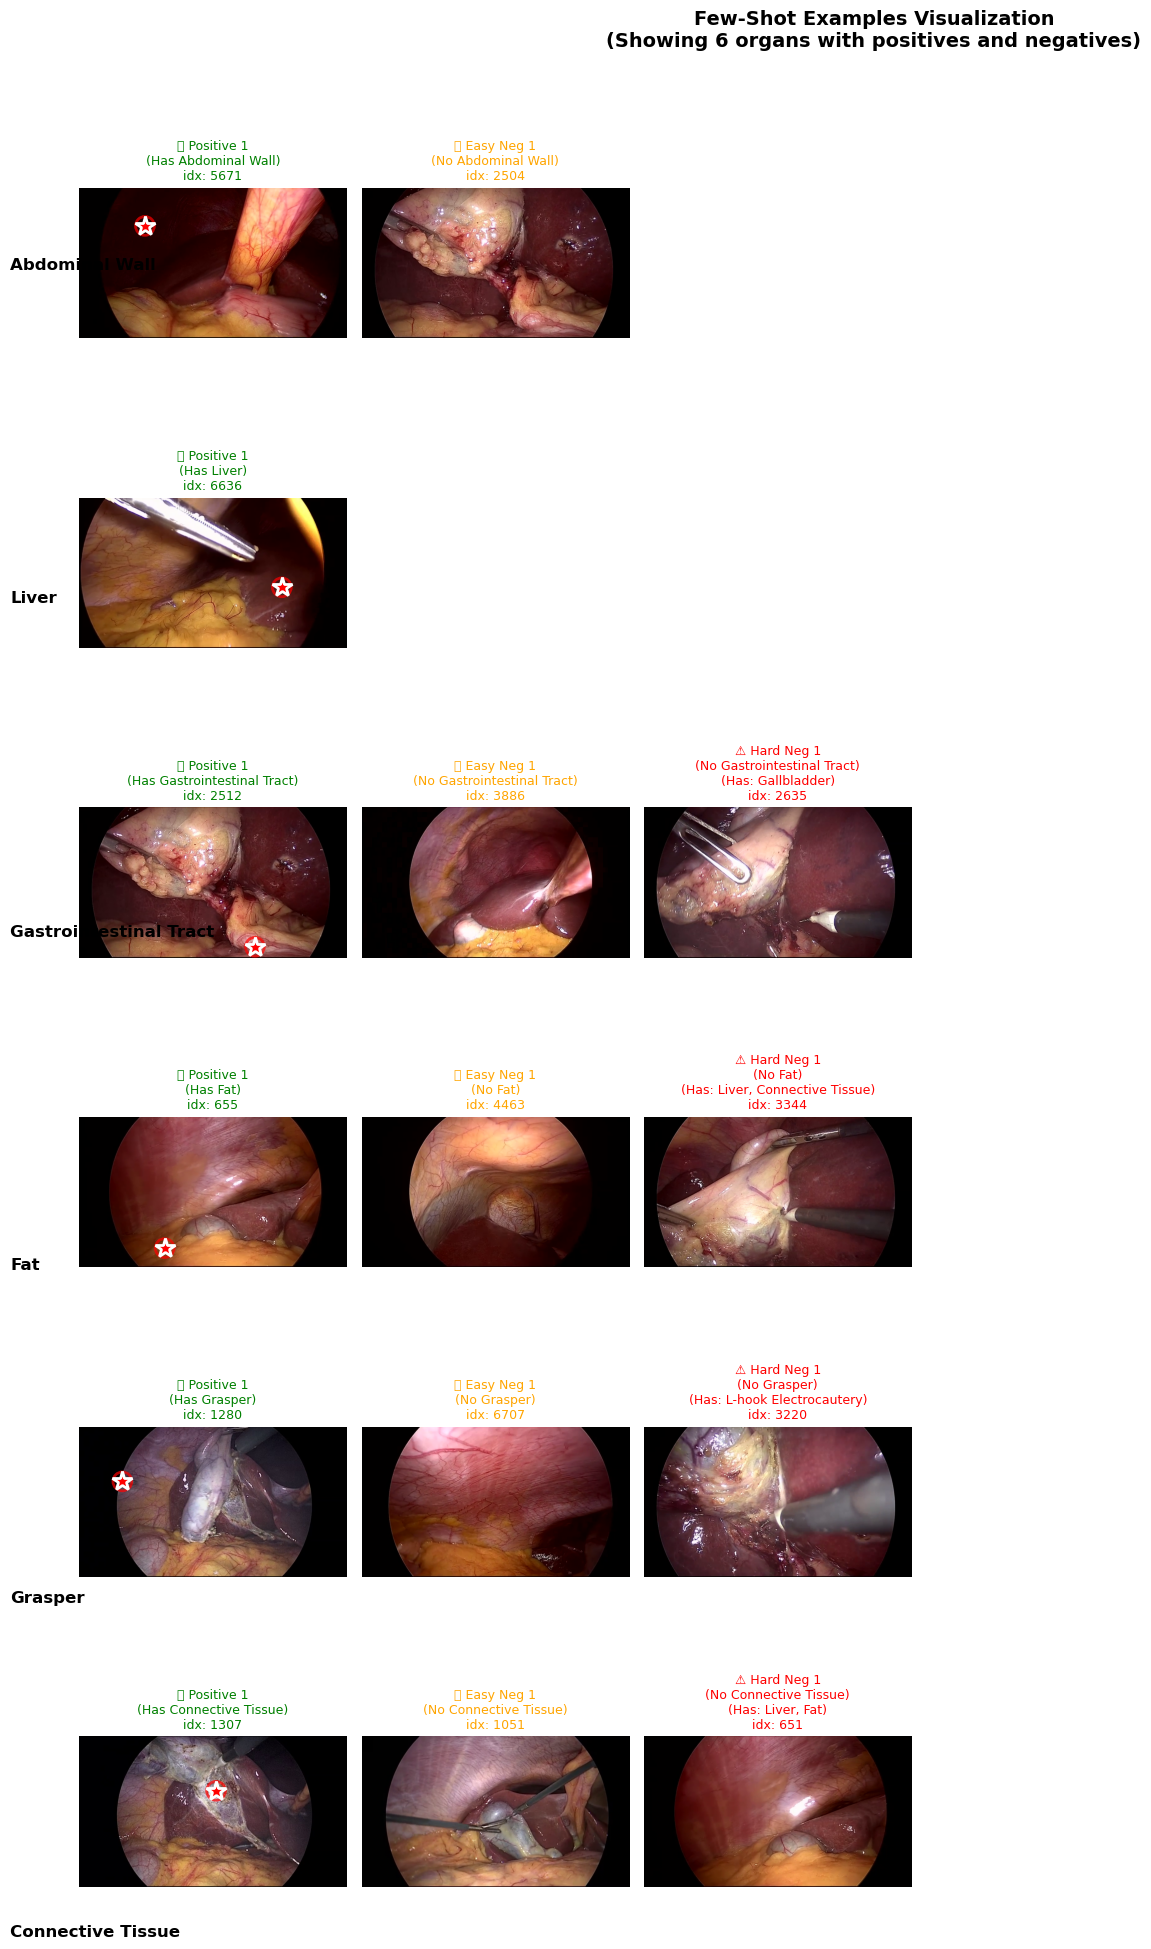


Visualizing organs 7-12 of 12...
✓ Visualization saved to: ../../data_info/cholecseg8k/fewshot_examples_visualization.png


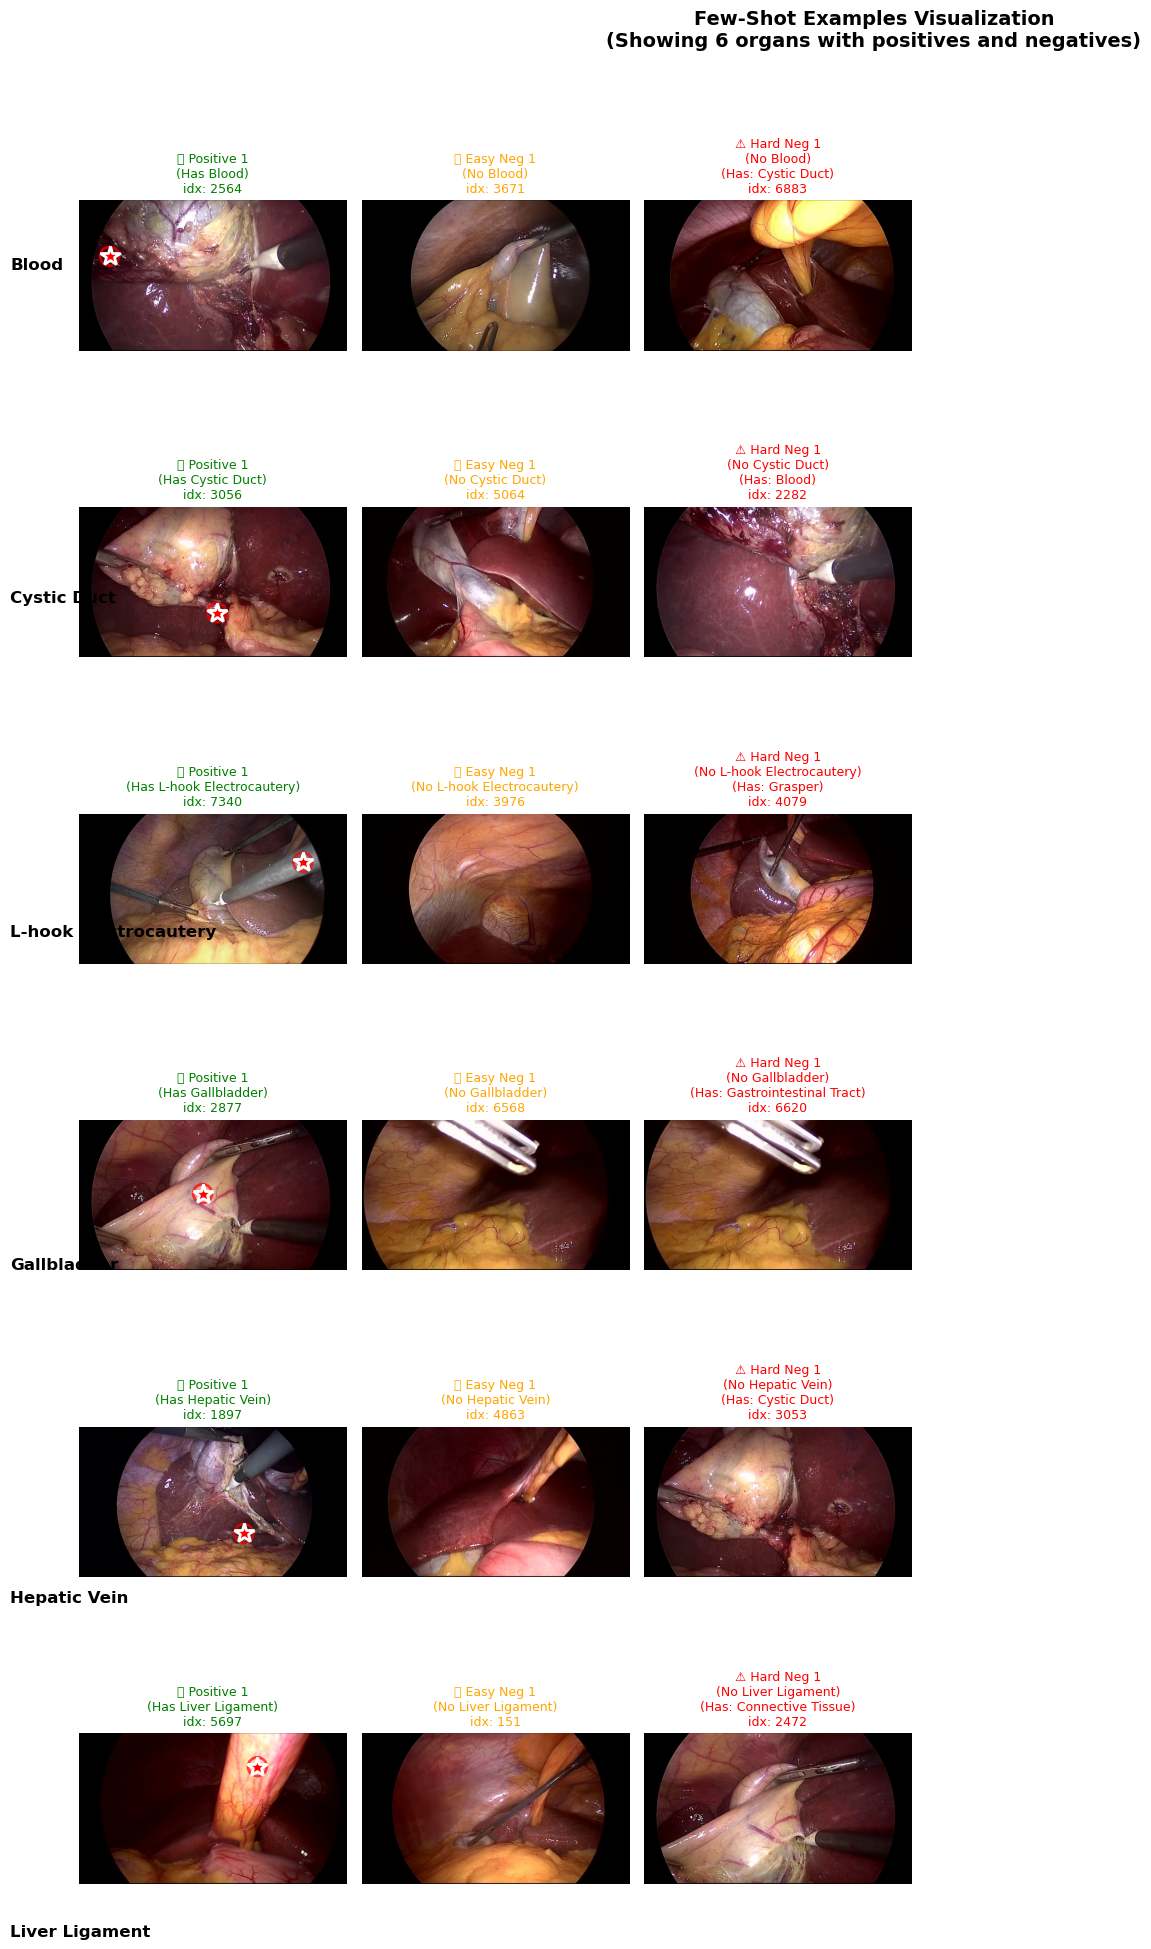

✓ Statistics saved to: ../../data_info/cholecseg8k/fewshot_statistics.png


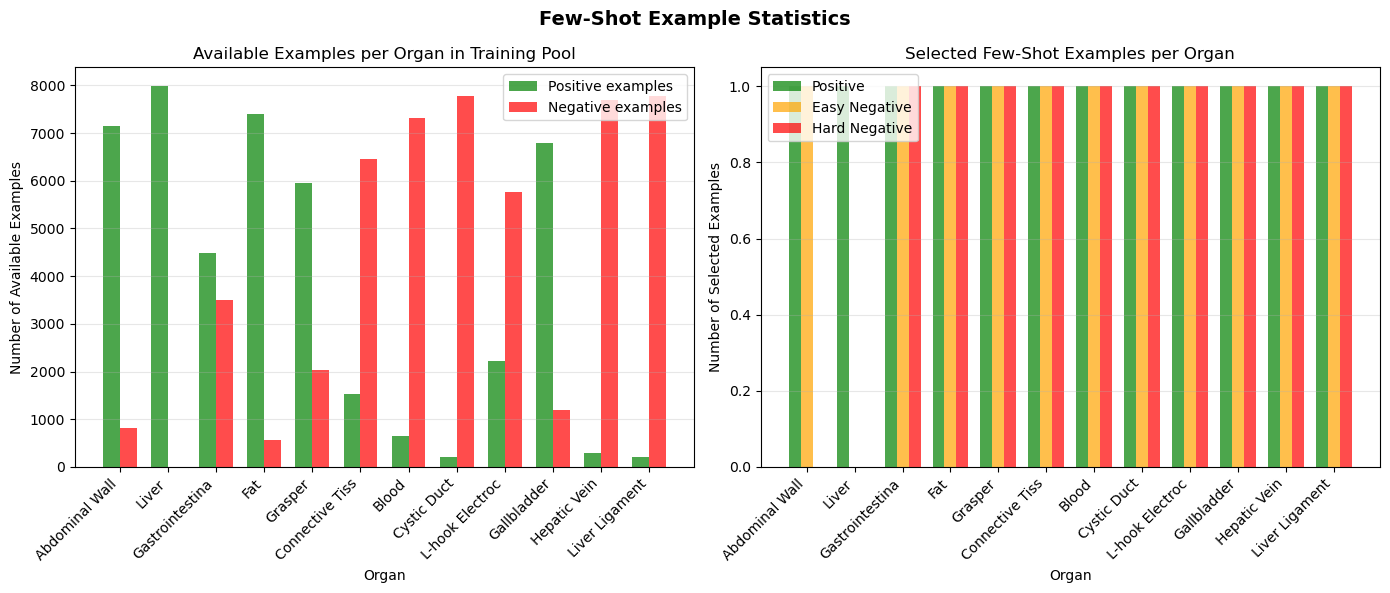


📊 Visualization complete! Check ../../data_info/cholecseg8k for saved images.


In [11]:
# Cell 10: Visualize few-shot examples
print("\n📊 Visualizing few-shot examples...")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import torchvision.transforms.functional as tvtf

def visualize_fewshot_examples(dataset, plan, organ_names_to_show=None, max_organs=4):
    """
    Visualize few-shot examples for selected organs.
    Shows positive examples with points and negative examples.
    """
    if organ_names_to_show is None:
        # Show first few organs with both positives and negatives
        organ_names_to_show = []
        for class_id_str, info in plan["plan"].items():
            if len(info["positives"]) > 0 and (len(info["negatives_easy"]) > 0 or len(info.get("negatives_hard", [])) > 0):
                organ_names_to_show.append(info["name"])
                if len(organ_names_to_show) >= max_organs:
                    break
    
    n_organs = len(organ_names_to_show)
    # Adjust figure size based on number of organs
    fig_height = min(4 * n_organs, 20)  # Cap at reasonable height
    fig = plt.figure(figsize=(18, fig_height))
    
    for organ_idx, organ_name in enumerate(organ_names_to_show):
        # Find the organ in the plan
        organ_info = None
        for class_id_str, info in plan["plan"].items():
            if info["name"] == organ_name:
                organ_info = info
                class_id = int(class_id_str)
                break
        
        if organ_info is None:
            continue
        
        # Create subplot for this organ
        # Each organ gets 1 row with: 1-2 positives, 1-2 easy negatives, 1-2 hard negatives
        n_pos = min(2, len(organ_info["positives"]))
        n_neg_easy = min(2, len(organ_info["negatives_easy"]))
        n_neg_hard = min(2, len(organ_info.get("negatives_hard", [])))
        n_cols = n_pos + n_neg_easy + n_neg_hard
        
        if n_cols == 0:
            continue
        
        col_idx = 0
        
        # Plot positive examples
        for i in range(n_pos):
            ax = plt.subplot(n_organs, 6, organ_idx * 6 + col_idx + 1)
            pos_data = organ_info["positives"][i]
            idx = pos_data["idx"]
            point = pos_data["point"]
            
            # Load and display image
            example = dataset[plan["split"]][idx]
            img = example["image"]
            ax.imshow(img)
            
            # Mark the point if available
            if point:
                ax.plot(point[0], point[1], 'r*', markersize=15, markeredgewidth=2, 
                       markeredgecolor='white', label='Organ location')
                # Add circle around point
                circle = patches.Circle((point[0], point[1]), 30, linewidth=2, 
                                       edgecolor='red', facecolor='none', alpha=0.7)
                ax.add_patch(circle)
            
            ax.set_title(f"✅ Positive {i+1}\n(Has {organ_name})\nidx: {idx}", fontsize=9, color='green')
            ax.axis('off')
            col_idx += 1
        
        # Plot easy negative examples
        for i in range(n_neg_easy):
            ax = plt.subplot(n_organs, 6, organ_idx * 6 + col_idx + 1)
            idx = organ_info["negatives_easy"][i]
            
            # Load and display image
            example = dataset[plan["split"]][idx]
            img = example["image"]
            ax.imshow(img)
            
            ax.set_title(f"❌ Easy Neg {i+1}\n(No {organ_name})\nidx: {idx}", fontsize=9, color='orange')
            ax.axis('off')
            col_idx += 1
        
        # Plot hard negative examples
        for i in range(n_neg_hard):
            ax = plt.subplot(n_organs, 6, organ_idx * 6 + col_idx + 1)
            idx = organ_info["negatives_hard"][i]
            
            # Load and display image
            example = dataset[plan["split"]][idx]
            img = example["image"]
            ax.imshow(img)
            
            # Try to identify what confusing organ is present
            from cholecseg8k_utils import example_to_tensors, labels_to_presence_vector, ID2LABEL, LABEL_IDS
            _, lab_t = example_to_tensors(example)
            presence = labels_to_presence_vector(lab_t)
            confuser_organs = []
            confuser_map = {
                2: [4, 6], 3: [1, 10], 4: [2, 6], 5: [9], 6: [2, 4],
                7: [8], 8: [7, 11], 9: [5], 10: [3], 11: [8], 12: [6]
            }
            if int(class_id_str) in confuser_map:
                for conf_id in confuser_map[int(class_id_str)]:
                    if conf_id in LABEL_IDS:
                        conf_idx = LABEL_IDS.index(conf_id)
                        if presence[conf_idx] == 1:
                            confuser_organs.append(ID2LABEL[conf_id])
            
            confuser_text = f"\n(Has: {', '.join(confuser_organs[:2])})" if confuser_organs else ""
            ax.set_title(f"⚠️ Hard Neg {i+1}\n(No {organ_name}){confuser_text}\nidx: {idx}", fontsize=9, color='red')
            ax.axis('off')
            col_idx += 1
        
        # Add organ name on the left
        fig.text(0.02, 0.9 - organ_idx / n_organs - 0.05, organ_name, 
                fontsize=12, fontweight='bold', rotation=0)
    
    plt.suptitle(f"Few-Shot Examples Visualization\n"
                 f"(Showing {n_organs} organs with positives and negatives)", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])
    
    # Save figure
    viz_path = CONFIG["output_dir"] / "fewshot_examples_visualization.png"
    plt.savefig(viz_path, dpi=100, bbox_inches='tight')
    print(f"✓ Visualization saved to: {viz_path}")
    
    plt.show()
    return fig

# Explain the difference between easy and hard negatives
print("\n📚 Understanding Easy vs Hard Negatives:")
print("="*60)
print("EASY NEGATIVES: Random images that don't contain the target organ")
print("  - Simple case: organ is clearly absent")
print("  - May be visually very different from positive examples")
print("")
print("HARD NEGATIVES: Images containing confusing/similar organs")
print("  - Challenging case: contains organs easily confused with target")
print("  - Examples of confusing pairs:")
print("    • Liver ↔ Fat (similar texture/color)")
print("    • Gallbladder ↔ GI Tract (similar shape)")
print("    • Grasper ↔ L-hook (both are instruments)")
print("    • Blood ↔ Cystic Duct (similar appearance)")
print("  - Tests model's ability to distinguish between similar structures")
print("="*60)

# Visualize examples from the hard negatives plan for ALL organs
print("\nVisualizing few-shot examples with hard negatives for ALL organs:")

# Get all organ names from the plan
all_organ_names = [info["name"] for info in plan_hard["plan"].values()]

# Create multiple figures if needed (6 organs per figure for readability)
organs_per_figure = 6
n_figures = (len(all_organ_names) + organs_per_figure - 1) // organs_per_figure

for fig_idx in range(n_figures):
    start_idx = fig_idx * organs_per_figure
    end_idx = min(start_idx + organs_per_figure, len(all_organ_names))
    organs_subset = all_organ_names[start_idx:end_idx]
    
    print(f"\nVisualizing organs {start_idx+1}-{end_idx} of {len(all_organ_names)}...")
    
    fig = visualize_fewshot_examples(
        dataset, 
        plan_hard,
        organ_names_to_show=organs_subset,
        max_organs=organs_per_figure
    )

# Also create a summary visualization showing statistics
fig2, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Number of available examples per organ
ax = axes[0]
organ_names = []
pos_counts = []
neg_counts = []

for class_id_str, info in plan_hard["plan"].items():
    organ_names.append(info["name"][:15])  # Truncate long names
    pos_counts.append(info["pos_available"])
    neg_counts.append(info["neg_available"])

x = np.arange(len(organ_names))
width = 0.35

bars1 = ax.bar(x - width/2, pos_counts, width, label='Positive examples', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, neg_counts, width, label='Negative examples', color='red', alpha=0.7)

ax.set_xlabel('Organ')
ax.set_ylabel('Number of Available Examples')
ax.set_title('Available Examples per Organ in Training Pool')
ax.set_xticks(x)
ax.set_xticklabels(organ_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Selected examples distribution
ax = axes[1]
selected_pos = []
selected_neg_easy = []
selected_neg_hard = []

for class_id_str, info in plan_hard["plan"].items():
    selected_pos.append(len(info["positives"]))
    selected_neg_easy.append(len(info["negatives_easy"]))
    selected_neg_hard.append(len(info.get("negatives_hard", [])))

x = np.arange(len(organ_names))
width = 0.25

bars1 = ax.bar(x - width, selected_pos, width, label='Positive', color='green', alpha=0.7)
bars2 = ax.bar(x, selected_neg_easy, width, label='Easy Negative', color='orange', alpha=0.7)
bars3 = ax.bar(x + width, selected_neg_hard, width, label='Hard Negative', color='red', alpha=0.7)

ax.set_xlabel('Organ')
ax.set_ylabel('Number of Selected Examples')
ax.set_title('Selected Few-Shot Examples per Organ')
ax.set_xticks(x)
ax.set_xticklabels(organ_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Few-Shot Example Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save statistics figure
stats_path = CONFIG["output_dir"] / "fewshot_statistics.png"
plt.savefig(stats_path, dpi=100, bbox_inches='tight')
print(f"✓ Statistics saved to: {stats_path}")

plt.show()

print(f"\n📊 Visualization complete! Check {CONFIG['output_dir']} for saved images.")



🔍 Visualizing near-miss hard negatives for pointing tasks...

Visualizing near-miss examples for selected organs:


/tmp/ipykernel_14762/4148111738.py:100: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_14762/4148111738.py:104: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.savefig(viz_path, dpi=100, bbox_inches='tight')


✓ Near-miss visualization saved to: ../../data_info/cholecseg8k/nearmiss_visualization.png


/opt/conda/envs/rapids/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


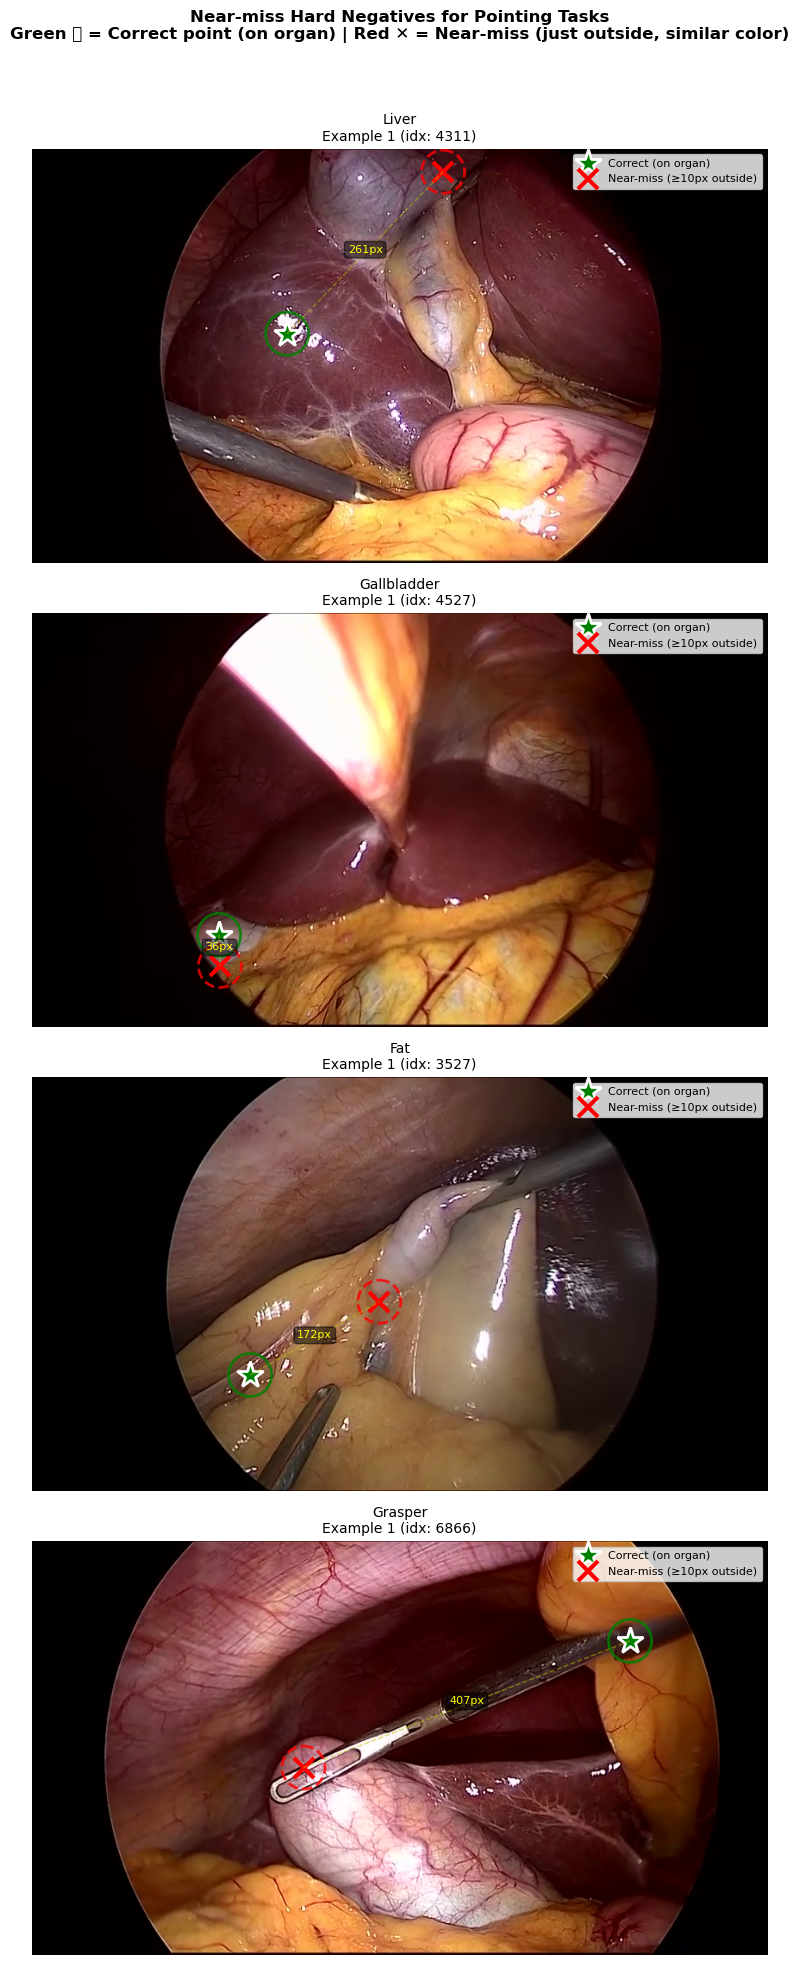


🎯 Near-miss visualization complete!


In [12]:
# Cell 10b: Visualize near-miss hard negatives
print("\n🔍 Visualizing near-miss hard negatives for pointing tasks...")

def visualize_nearmiss_examples(dataset, plan, organ_names_to_show=None, max_organs=4):
    """
    Visualize near-miss hard negative examples for pointing tasks.
    Shows the same image with positive point (on organ) and near-miss point (just outside).
    """
    # Import required functions
    from cholecseg8k_utils import example_to_tensors
    from few_shot_selection import sample_point_in_mask
    import numpy as np
    
    if organ_names_to_show is None:
        # Show organs that have near-miss examples
        organ_names_to_show = []
        for class_id_str, info in plan["plan"].items():
            if len(info.get("near_miss", [])) > 0:
                organ_names_to_show.append(info["name"])
                if len(organ_names_to_show) >= max_organs:
                    break
    
    n_organs = min(len(organ_names_to_show), max_organs)
    fig = plt.figure(figsize=(16, 5 * n_organs))
    
    for organ_idx, organ_name in enumerate(organ_names_to_show[:n_organs]):
        # Find the organ in the plan
        organ_info = None
        class_id_str = None
        for cid_str, info in plan["plan"].items():
            if info["name"] == organ_name:
                organ_info = info
                class_id_str = cid_str
                class_id = int(cid_str)
                break
        
        if organ_info is None or len(organ_info.get("near_miss", [])) == 0:
            continue
        
        # Show up to 3 near-miss examples
        n_examples = min(3, len(organ_info["near_miss"]))
        
        for ex_idx in range(n_examples):
            # Get near-miss example
            nm_data = organ_info["near_miss"][ex_idx]
            idx = nm_data["idx"]
            nm_point = nm_data["point"]
            
            # Load image
            example = dataset[plan["split"]][idx]
            img = example["image"]
            
            # Get the correct positive point for comparison
            img_t, lab_t = example_to_tensors(example)
            pos_point = sample_point_in_mask(lab_t, class_id, strategy="interior")
            
            # Create subplot
            ax = plt.subplot(n_organs, n_examples, organ_idx * n_examples + ex_idx + 1)
            ax.imshow(img)
            
            # Show both points
            if pos_point:
                # Positive point (green)
                ax.plot(pos_point[0], pos_point[1], 'g*', markersize=20, markeredgewidth=2,
                       markeredgecolor='white', label='Correct (on organ)')
                circle_pos = patches.Circle((pos_point[0], pos_point[1]), 25, linewidth=2,
                                           edgecolor='green', facecolor='none', alpha=0.8)
                ax.add_patch(circle_pos)
            
            if nm_point:
                # Near-miss point (red)
                ax.plot(nm_point[0], nm_point[1], 'rx', markersize=15, markeredgewidth=3,
                       label='Near-miss (≥10px outside)')
                circle_nm = patches.Circle((nm_point[0], nm_point[1]), 25, linewidth=2,
                                          edgecolor='red', facecolor='none', alpha=0.8, linestyle='--')
                ax.add_patch(circle_nm)
                
                # Draw line between points to show distance
                if pos_point:
                    # Calculate and show distance
                    distance = np.sqrt((pos_point[0] - nm_point[0])**2 + (pos_point[1] - nm_point[1])**2)
                    ax.plot([pos_point[0], nm_point[0]], [pos_point[1], nm_point[1]], 
                           'y--', alpha=0.5, linewidth=1)
                    # Add distance text at midpoint
                    mid_x = (pos_point[0] + nm_point[0]) / 2
                    mid_y = (pos_point[1] + nm_point[1]) / 2
                    ax.text(mid_x, mid_y, f'{distance:.0f}px', 
                           color='yellow', fontsize=8, ha='center',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.5))
            
            ax.set_title(f"{organ_name}\nExample {ex_idx+1} (idx: {idx})", fontsize=10)
            ax.axis('off')
            
            if ex_idx == 0:
                ax.legend(loc='upper right', fontsize=8, framealpha=0.8)
    
    plt.suptitle("Near-miss Hard Negatives for Pointing Tasks\n"
                 "Green ⭐ = Correct point (on organ) | Red ✕ = Near-miss (just outside, similar color)",
                 fontsize=12, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save figure
    viz_path = CONFIG["output_dir"] / "nearmiss_visualization.png"
    plt.savefig(viz_path, dpi=100, bbox_inches='tight')
    print(f"✓ Near-miss visualization saved to: {viz_path}")
    
    plt.show()
    return fig

# Visualize near-miss examples
print("\nVisualizing near-miss examples for selected organs:")
fig_nm = visualize_nearmiss_examples(
    dataset,
    plan_nearmiss,
    organ_names_to_show=["Liver", "Gallbladder", "Fat", "Grasper"],
    max_organs=4
)

print(f"\n🎯 Near-miss visualization complete!")


In [13]:
# Cell 11: Verify saved files
print("\n📁 Verifying saved files...")

# Load and verify balanced indices
loaded_balanced = load_balanced_indices(balanced_file)
assert len(loaded_balanced) == CONFIG["n_test_samples"]
print(f"✓ Balanced indices: {len(loaded_balanced)} samples")

# Load and verify few-shot plans
loaded_plan_easy = load_fewshot_plan(plan_easy_file)
loaded_plan_hard = load_fewshot_plan(plan_hard_file)

print(f"✓ Few-shot plan (easy): {len(loaded_plan_easy['plan'])} organs")
print(f"✓ Few-shot plan (hard): {len(loaded_plan_hard['plan'])} organs")



📁 Verifying saved files...
✓ Balanced indices: 100 samples
✓ Few-shot plan (easy): 12 organs
✓ Few-shot plan (hard): 12 organs


In [14]:
# Cell 12: Create summary report
print("\n📝 Creating summary report...")

summary = {
    "timestamp": datetime.now().isoformat(),
    "dataset": "CholecSeg8k",
    "configuration": {
        "n_test_samples": CONFIG["n_test_samples"],
        "n_pos_examples": CONFIG["n_pos_examples"],
        "n_neg_easy": CONFIG["n_neg_easy"],
        "n_neg_hard": CONFIG["n_neg_hard"],
        "min_pixels": CONFIG["min_pixels"],
        "seed": CONFIG["seed"]
    },
    "files_created": {
        "balanced_indices": str(balanced_file),
        "fewshot_plan_easy": str(plan_easy_file),
        "fewshot_plan_hard": str(plan_hard_file)
    },
    "statistics": {
        "total_train_samples": train_size,
        "organ_distribution_original": {
            ID2LABEL[LABEL_IDS[i]]: int(organ_counts[i]) 
            for i in range(len(LABEL_IDS))
        },
        "organ_distribution_balanced": {
            ID2LABEL[LABEL_IDS[i]]: int(balanced_counts[i])
            for i in range(len(LABEL_IDS))
        }
    }
}

summary_file = CONFIG["output_dir"] / "preparation_summary.json"
with open(summary_file, "w") as f:
    json.dump(summary, f, indent=2)

print(f"✓ Summary saved to: {summary_file}")



📝 Creating summary report...
✓ Summary saved to: ../../data_info/cholecseg8k/preparation_summary.json


In [15]:
# Cell 13: Display final summary
print("\n" + "="*60)
print("✨ Few-shot example preparation complete!")
print("="*60)
print(f"\nFiles created in {CONFIG['output_dir']}:")
print(f"  1. Balanced test set: {balanced_file.name}")
print(f"     - {CONFIG['n_test_samples']} samples for evaluation")
print(f"  2. Few-shot plan (easy): {plan_easy_file.name}")
print(f"     - {CONFIG['n_pos_examples']} positive, {CONFIG['n_neg_easy']} easy negative per organ")
print(f"  3. Few-shot plan (confuser hard): {plan_hard_file.name}")
print(f"     - {CONFIG['n_pos_examples']} positive, {CONFIG['n_neg_easy']} easy + {CONFIG['n_neg_hard']} confuser negatives per organ")
print(f"  4. Few-shot plan (near-miss): {plan_nearmiss_file.name}")
print(f"     - {CONFIG['n_pos_examples']} positive with correct points")
print(f"     - {CONFIG['n_neg_easy']} easy negatives (no organ)")
print(f"     - {CONFIG['n_neg_hard']} near-miss points (just outside organ boundary)")
print(f"\n📌 Usage:")
print("  • Confuser hard negatives: For existence detection (is organ present?)")
print("  • Near-miss hard negatives: For pointing tasks (precise localization)")
print("\nNext step: Run evaluation using these prepared examples.")


✨ Few-shot example preparation complete!

Files created in ../../data_info/cholecseg8k:
  1. Balanced test set: balanced_indices_train_100.json
     - 100 samples for evaluation
  2. Few-shot plan (easy): fewshot_plan_train_pos1_neg1_seed43_excl100.json
     - 1 positive, 1 easy negative per organ
  3. Few-shot plan (confuser hard): fewshot_plan_train_pos1_nege1_negh1_seed44_excl100.json
     - 1 positive, 1 easy + 1 confuser negatives per organ
  4. Few-shot plan (near-miss): fewshot_plan_train_pos1_neg1_nearmiss1_seed45_excl100.json
     - 1 positive with correct points
     - 1 easy negatives (no organ)
     - 1 near-miss points (just outside organ boundary)

📌 Usage:
  • Confuser hard negatives: For existence detection (is organ present?)
  • Near-miss hard negatives: For pointing tasks (precise localization)

Next step: Run evaluation using these prepared examples.
